# Food Delivery Time Prediction Project

This notebook contains the complete workflow for predicting food delivery times using machine learning techniques.

## Project Phases:
1. **Phase 1**: Data Collection and Exploratory Data Analysis (EDA)
2. **Phase 2**: Predictive Modeling (Linear & Logistic Regression)
3. **Phase 3**: Reporting and Insights

---

## Library Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# Geospatial calculations
from geopy.distance import geodesic

# Utilities
from datetime import datetime
import joblib

# Settings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
%matplotlib inline

---
# Phase 1: Data Collection and Exploratory Data Analysis (EDA)
---

## Step 1: Data Import and Preprocessing

In [2]:
# Load the dataset
try:
    df = pd.read_csv('../data/Food_Delivery_Time_Prediction.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Dataset not found. Please place 'Food_Delivery_Time_Prediction.csv' in the 'data/' directory.")
    # Create sample data structure for demonstration
    df = pd.DataFrame({
        'Customer_Lat': np.random.uniform(40.7, 40.8, 1000),
        'Customer_Lng': np.random.uniform(-74.0, -73.9, 1000),
        'Restaurant_Lat': np.random.uniform(40.7, 40.8, 1000),
        'Restaurant_Lng': np.random.uniform(-74.0, -73.9, 1000),
        'Weather_Conditions': np.random.choice(['Sunny', 'Rainy', 'Cloudy'], 1000),
        'Traffic_Conditions': np.random.choice(['Low', 'Medium', 'High'], 1000),
        'Vehicle_Type': np.random.choice(['Bike', 'Scooter', 'Car'], 1000),
        'Order_Cost': np.random.uniform(10, 100, 1000),
        'Delivery_Time': np.random.uniform(15, 60, 1000)
    })
    print("Using sample data for demonstration.")

Dataset loaded successfully!
Shape: (200, 15)


In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost           

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [4]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")
    print(f"Percentage of missing data: {(missing_values.sum() / len(df)) * 100:.2f}%")

Missing Values:
Series([], dtype: int64)
No missing values found!


In [5]:
# Handle missing values (if any)
# Strategy: 
# - Numerical: Fill with median
# - Categorical: Fill with mode

def handle_missing_values(df):
    df_clean = df.copy()
    
    # Numerical columns
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
            print(f"Filled {col} with median: {df_clean[col].median():.2f}")
    
    # Categorical columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} with mode: {mode_val}")
    
    return df_clean

df_clean = handle_missing_values(df)
print(f"\nCleaned dataset shape: {df_clean.shape}")


Cleaned dataset shape: (200, 15)


## Step 2: Exploratory Data Analysis (EDA)

In [6]:
# Descriptive Statistics
print("Descriptive Statistics for Numerical Features:")
df_clean.describe()

Descriptive Statistics for Numerical Features:


,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,11.498050,5.250000,3.738500,3.686500,70.494950,1046.488700,46.616650
std,6.841755,2.745027,0.703021,0.697063,29.830694,548.568922,29.361706
min,0.520000,1.000000,2.500000,2.600000,15.230000,122.300000,1.240000
25%,6.090000,3.000000,3.200000,3.100000,46.997500,553.270000,21.602500
50%,10.265000,5.000000,3.800000,3.700000,72.775000,1035.950000,47.530000
75%,16.497500,8.000000,4.300000,4.300000,96.650000,1543.125000,70.245000
max,24.900000,10.000000,5.000000,5.000000,119.670000,1997.420000,99.740000


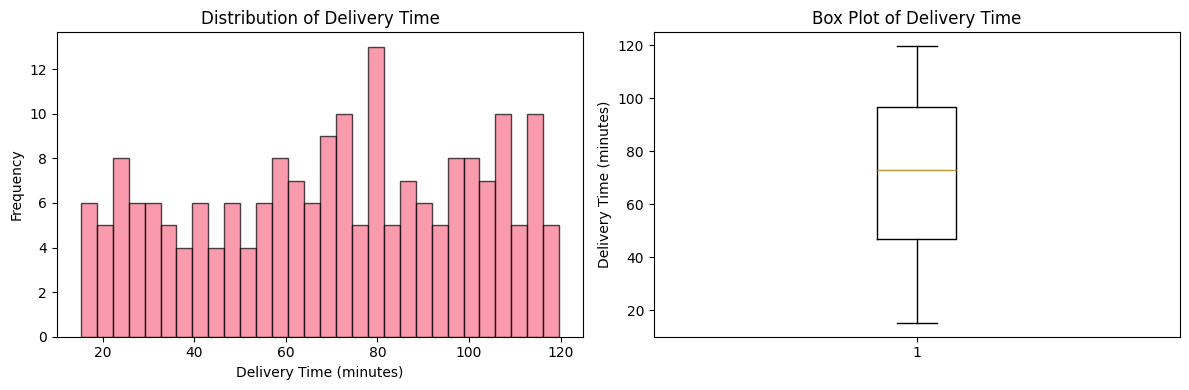

Mean Delivery Time: 70.49 minutes
Median Delivery Time: 72.78 minutes
Standard Deviation: 29.83 minutes


In [7]:
# Distribution of target variable (Delivery_Time)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean['Delivery_Time'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['Delivery_Time'])
plt.title('Box Plot of Delivery Time')
plt.ylabel('Delivery Time (minutes)')

plt.tight_layout()
plt.show()

print(f"Mean Delivery Time: {df_clean['Delivery_Time'].mean():.2f} minutes")
print(f"Median Delivery Time: {df_clean['Delivery_Time'].median():.2f} minutes")
print(f"Standard Deviation: {df_clean['Delivery_Time'].std():.2f} minutes")

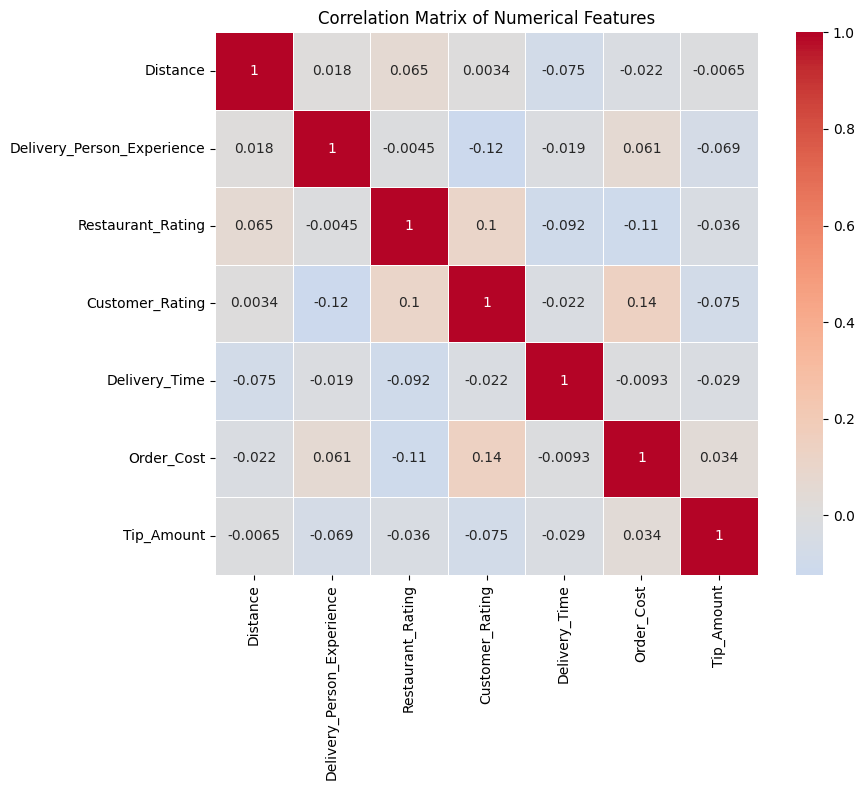


Correlations with Delivery Time:
Order_Cost: -0.009
Delivery_Person_Experience: -0.019
Customer_Rating: -0.022
Tip_Amount: -0.029
Distance: -0.075
Restaurant_Rating: -0.092


In [8]:
# Correlation Analysis
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Show correlations with target variable
if 'Delivery_Time' in correlation_matrix.columns:
    target_correlations = correlation_matrix['Delivery_Time'].sort_values(ascending=False)
    print("\nCorrelations with Delivery Time:")
    for feature, corr in target_correlations.items():
        if feature != 'Delivery_Time':
            print(f"{feature}: {corr:.3f}")

Number of outliers in Delivery Time: 0
Percentage of outliers: 0.00%
Outlier bounds: [-27.48, 171.13]


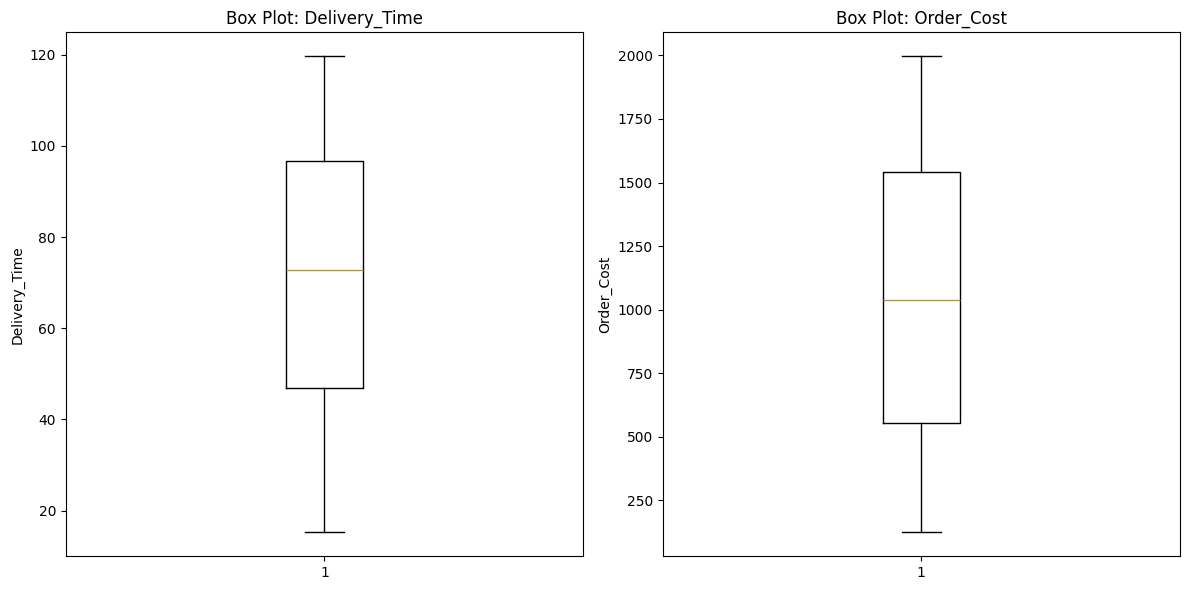

In [9]:
# Outlier Detection
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in delivery time
outliers, lower, upper = detect_outliers(df_clean, 'Delivery_Time')
print(f"Number of outliers in Delivery Time: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers) / len(df_clean)) * 100:.2f}%")
print(f"Outlier bounds: [{lower:.2f}, {upper:.2f}]")

# Visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Delivery_Time', 'Order_Cost'], 1):
    plt.subplot(1, 2, i)
    plt.boxplot(df_clean[col])
    plt.title(f'Box Plot: {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Step 3: Feature Engineering

In [11]:
# Calculate distance between customer and restaurant using Haversine formula
def calculate_distance(row):
    if all(col in row.index for col in ['Customer_Lat', 'Customer_Lng', 'Restaurant_Lat', 'Restaurant_Lng']):
        customer_coords = (row['Customer_Lat'], row['Customer_Lng'])
        restaurant_coords = (row['Restaurant_Lat'], row['Restaurant_Lng'])
        return geodesic(customer_coords, restaurant_coords).kilometers
    else:
        return np.random.uniform(1, 20)  # Random distance for demo data

df_engineered = df_clean.copy()
df_engineered['Distance_km'] = df_engineered.apply(calculate_distance, axis=1)

print(f"Distance calculated. Mean distance: {df_engineered['Distance_km'].mean():.2f} km")

Distance calculated. Mean distance: 10.17 km


In [12]:
# Create time-based features (if timestamp data available)
# For demonstration, we'll create a rush hour feature based on random time
np.random.seed(42)
df_engineered['Hour'] = np.random.randint(0, 24, len(df_engineered))
df_engineered['Is_Rush_Hour'] = df_engineered['Hour'].apply(
    lambda x: 1 if (11 <= x <= 13) or (18 <= x <= 20) else 0
)

print("Time-based features created:")
print(f"Rush hour orders: {df_engineered['Is_Rush_Hour'].sum()}")
print(f"Non-rush hour orders: {len(df_engineered) - df_engineered['Is_Rush_Hour'].sum()}")

Time-based features created:
Rush hour orders: 51
Non-rush hour orders: 149


In [13]:
# Encode categorical variables
categorical_cols = df_engineered.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {list(categorical_cols)}")

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df_engineered, columns=categorical_cols, drop_first=True)

print(f"Dataset shape after encoding: {df_encoded.shape}")
print(f"New columns created: {df_encoded.shape[1] - df_engineered.shape[1]}")

Categorical columns to encode: ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
Dataset shape after encoding: (200, 619)
New columns created: 601


---
# Phase 2: Predictive Modeling
---

## Step 4: Linear Regression Model for Delivery Time Prediction

In [14]:
# Prepare data for linear regression
# Target variable: Delivery_Time
# Features: All other variables

X = df_encoded.drop(['Delivery_Time'], axis=1)
y = df_encoded['Delivery_Time']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

Features shape: (200, 618)
Target shape: (200,)
Feature columns: ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Distance_km', 'Hour', 'Is_Rush_Hour', 'Order_ID_ORD0002', 'Order_ID_ORD0003', 'Order_ID_ORD0004', 'Order_ID_ORD0005', 'Order_ID_ORD0006', 'Order_ID_ORD0007', 'Order_ID_ORD0008', 'Order_ID_ORD0009', 'Order_ID_ORD0010', 'Order_ID_ORD0011', 'Order_ID_ORD0012', 'Order_ID_ORD0013', 'Order_ID_ORD0014', 'Order_ID_ORD0015', 'Order_ID_ORD0016', 'Order_ID_ORD0017', 'Order_ID_ORD0018', 'Order_ID_ORD0019', 'Order_ID_ORD0020', 'Order_ID_ORD0021', 'Order_ID_ORD0022', 'Order_ID_ORD0023', 'Order_ID_ORD0024', 'Order_ID_ORD0025', 'Order_ID_ORD0026', 'Order_ID_ORD0027', 'Order_ID_ORD0028', 'Order_ID_ORD0029', 'Order_ID_ORD0030', 'Order_ID_ORD0031', 'Order_ID_ORD0032', 'Order_ID_ORD0033', 'Order_ID_ORD0034', 'Order_ID_ORD0035', 'Order_ID_ORD0036', 'Order_ID_ORD0037', 'Order_ID_ORD0038', 'Order_ID_ORD0039', 'Order_ID_ORD0040', 'Orde

In [15]:
# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 160
Test set size: 40


In [16]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized.")
print(f"Training set mean: {X_train_scaled.mean():.6f}")
print(f"Training set std: {X_train_scaled.std():.6f}")

Features standardized.
Training set mean: -0.000000
Training set std: 0.897678


In [17]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

print("Linear Regression model trained successfully!")

Linear Regression model trained successfully!


In [18]:
# Evaluate Linear Regression model
def evaluate_regression_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n{dataset_name} Set Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on training and test sets
train_metrics = evaluate_regression_model(y_train, y_train_pred, "Training")
test_metrics = evaluate_regression_model(y_test, y_test_pred, "Test")


Training Set Evaluation:
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
Mean Absolute Error (MAE): 0.00
R-squared (R²): 1.0000

Test Set Evaluation:
Mean Squared Error (MSE): 933.54
Root Mean Squared Error (RMSE): 30.55
Mean Absolute Error (MAE): 25.50
R-squared (R²): -0.0094


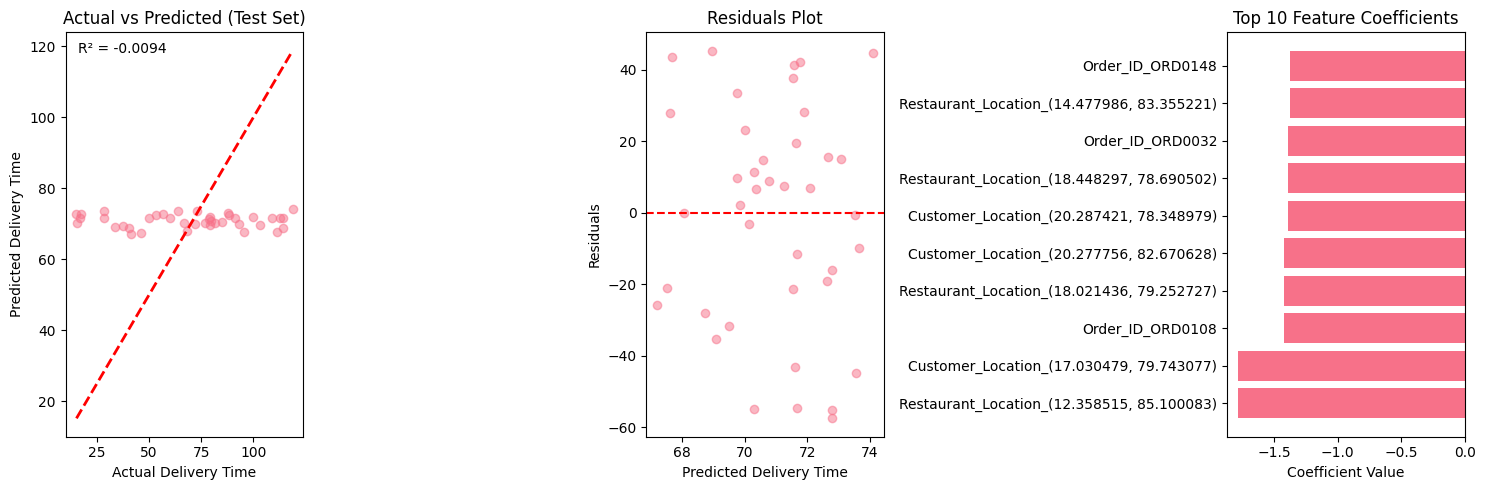

In [19]:
# Visualize Linear Regression results
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted (Test Set)')
plt.text(0.05, 0.95, f'R² = {test_metrics["R2"]:.4f}', transform=plt.gca().transAxes)

# Residuals plot
plt.subplot(1, 3, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Feature importance (coefficients)
plt.subplot(1, 3, 3)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
})
feature_importance = feature_importance.sort_values('coefficient', key=abs, ascending=False).head(10)
plt.barh(range(len(feature_importance)), feature_importance['coefficient'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients')

plt.tight_layout()
plt.show()

## Step 5: Logistic Regression Model for Delivery Classification

In [20]:
# Create binary target for logistic regression
# Classify deliveries as "Fast" (0) or "Delayed" (1)
# Using median delivery time as threshold

delivery_time_median = df_encoded['Delivery_Time'].median()
df_classification = df_encoded.copy()
df_classification['Delivery_Status'] = (df_classification['Delivery_Time'] > delivery_time_median).astype(int)

print(f"Delivery time threshold: {delivery_time_median:.2f} minutes")
print(f"Fast deliveries (0): {(df_classification['Delivery_Status'] == 0).sum()}")
print(f"Delayed deliveries (1): {(df_classification['Delivery_Status'] == 1).sum()}")
print(f"Class distribution: {df_classification['Delivery_Status'].value_counts(normalize=True)}")

Delivery time threshold: 72.78 minutes
Fast deliveries (0): 100
Delayed deliveries (1): 100
Class distribution: Delivery_Status
0    0.5
1    0.5
Name: proportion, dtype: float64


In [21]:
# Prepare data for logistic regression
X_class = df_classification.drop(['Delivery_Time', 'Delivery_Status'], axis=1)
y_class = df_classification['Delivery_Status']

# Train-test split for classification
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Standardize features for logistic regression
scaler_class = StandardScaler()
X_class_train_scaled = scaler_class.fit_transform(X_class_train)
X_class_test_scaled = scaler_class.transform(X_class_test)

print(f"Classification dataset prepared.")
print(f"Training set size: {X_class_train.shape[0]}")
print(f"Test set size: {X_class_test.shape[0]}")

Classification dataset prepared.
Training set size: 160
Test set size: 40


In [22]:
# Train Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_class_train_scaled, y_class_train)

# Make predictions
y_class_train_pred = logistic_model.predict(X_class_train_scaled)
y_class_test_pred = logistic_model.predict(X_class_test_scaled)
y_class_test_pred_proba = logistic_model.predict_proba(X_class_test_scaled)[:, 1]

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


In [23]:
# Evaluate Logistic Regression model
def evaluate_classification_model(y_true, y_pred, y_pred_proba, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n{dataset_name} Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    
    return {
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 
        'F1': f1, 'AUC': auc
    }

# Evaluate on training and test sets
train_class_metrics = evaluate_classification_model(
    y_class_train, y_class_train_pred, 
    logistic_model.predict_proba(X_class_train_scaled)[:, 1], "Training"
)
test_class_metrics = evaluate_classification_model(
    y_class_test, y_class_test_pred, y_class_test_pred_proba, "Test"
)


Training Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000

Test Set Evaluation:
Accuracy: 0.4500
Precision: 0.4545
Recall: 0.5000
F1-Score: 0.4762
ROC AUC: 0.4225


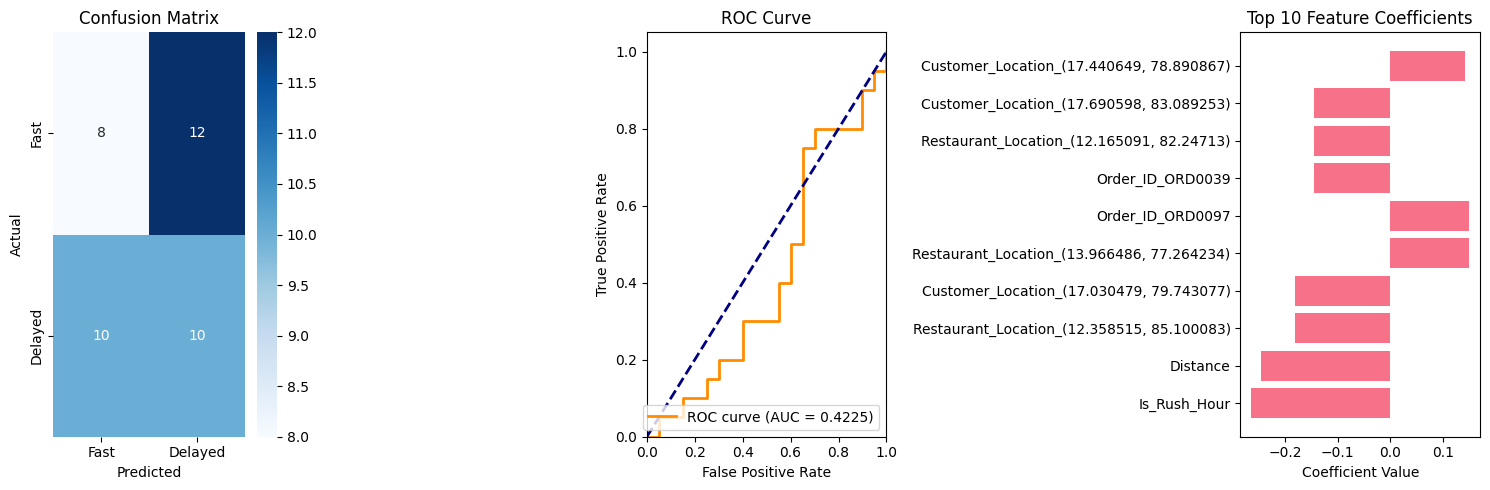

In [24]:
# Visualize Classification results
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_class_test, y_class_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fast', 'Delayed'], 
            yticklabels=['Fast', 'Delayed'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_class_test, y_class_test_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {test_class_metrics["AUC"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Feature importance (coefficients)
plt.subplot(1, 3, 3)
class_feature_importance = pd.DataFrame({
    'feature': X_class.columns,
    'coefficient': logistic_model.coef_[0]
})
class_feature_importance = class_feature_importance.sort_values(
    'coefficient', key=abs, ascending=False
).head(10)
plt.barh(range(len(class_feature_importance)), class_feature_importance['coefficient'])
plt.yticks(range(len(class_feature_importance)), class_feature_importance['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients')

plt.tight_layout()
plt.show()

---
# Phase 3: Reporting and Insights
---

## Step 6: Model Evaluation and Comparison

In [25]:
# Model Performance Summary
print("=" * 60)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 60)

print("\n1. LINEAR REGRESSION MODEL (Delivery Time Prediction):")
print("-" * 50)
for metric, value in test_metrics.items():
    print(f"{metric:15}: {value:.4f}")

print("\n2. LOGISTIC REGRESSION MODEL (Fast/Delayed Classification):")
print("-" * 50)
for metric, value in test_class_metrics.items():
    print(f"{metric:15}: {value:.4f}")

print("\n" + "=" * 60)

MODEL PERFORMANCE SUMMARY

1. LINEAR REGRESSION MODEL (Delivery Time Prediction):
--------------------------------------------------
MSE            : 933.5423
RMSE           : 30.5539
MAE            : 25.4967
R2             : -0.0094

2. LOGISTIC REGRESSION MODEL (Fast/Delayed Classification):
--------------------------------------------------
Accuracy       : 0.4500
Precision      : 0.4545
Recall         : 0.5000
F1             : 0.4762
AUC            : 0.4225



In [26]:
# Model interpretation
print("MODEL INTERPRETATION:")
print("\n1. Linear Regression Model:")
if test_metrics['R2'] > 0.7:
    print("   ✓ Excellent model performance (R² > 0.7)")
elif test_metrics['R2'] > 0.5:
    print("   ✓ Good model performance (R² > 0.5)")
else:
    print("   ⚠ Model may need improvement (R² < 0.5)")

print(f"   - The model explains {test_metrics['R2']*100:.1f}% of the variance in delivery time")
print(f"   - Average prediction error: {test_metrics['MAE']:.1f} minutes")

print("\n2. Logistic Regression Model:")
if test_class_metrics['Accuracy'] > 0.8:
    print("   ✓ High accuracy classification model")
elif test_class_metrics['Accuracy'] > 0.7:
    print("   ✓ Good accuracy classification model")
else:
    print("   ⚠ Classification model may need improvement")

print(f"   - Correctly classifies {test_class_metrics['Accuracy']*100:.1f}% of deliveries")
print(f"   - F1-Score: {test_class_metrics['F1']:.3f} (balance between precision and recall)")

MODEL INTERPRETATION:

1. Linear Regression Model:
   ⚠ Model may need improvement (R² < 0.5)
   - The model explains -0.9% of the variance in delivery time
   - Average prediction error: 25.5 minutes

2. Logistic Regression Model:
   ⚠ Classification model may need improvement
   - Correctly classifies 45.0% of deliveries
   - F1-Score: 0.476 (balance between precision and recall)


## Step 7: Actionable Insights and Recommendations

In [27]:
# Analysis of key factors affecting delivery time
print("KEY INSIGHTS FROM THE ANALYSIS:")
print("=" * 50)

# Top factors from linear regression
top_factors = feature_importance.head(5)
print("\n1. TOP FACTORS AFFECTING DELIVERY TIME:")
for idx, row in top_factors.iterrows():
    impact = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"   • {row['feature']}: {impact} delivery time by {abs(row['coefficient']):.2f} minutes")

# Rush hour analysis
if 'Is_Rush_Hour' in df_engineered.columns:
    rush_avg = df_engineered[df_engineered['Is_Rush_Hour']==1]['Delivery_Time'].mean()
    non_rush_avg = df_engineered[df_engineered['Is_Rush_Hour']==0]['Delivery_Time'].mean()
    print(f"\n2. RUSH HOUR IMPACT:")
    print(f"   • Rush hour average delivery time: {rush_avg:.1f} minutes")
    print(f"   • Non-rush hour average delivery time: {non_rush_avg:.1f} minutes")
    print(f"   • Rush hour increases delivery time by: {rush_avg - non_rush_avg:.1f} minutes")

# Distance impact
if 'Distance_km' in df_engineered.columns:
    distance_corr = df_engineered['Distance_km'].corr(df_engineered['Delivery_Time'])
    print(f"\n3. DISTANCE IMPACT:")
    print(f"   • Distance-delivery time correlation: {distance_corr:.3f}")
    print(f"   • Average distance: {df_engineered['Distance_km'].mean():.1f} km")

KEY INSIGHTS FROM THE ANALYSIS:

1. TOP FACTORS AFFECTING DELIVERY TIME:
   • Restaurant_Location_(12.358515, 85.100083): decreases delivery time by 1.78 minutes
   • Customer_Location_(17.030479, 79.743077): decreases delivery time by 1.78 minutes
   • Order_ID_ORD0108: decreases delivery time by 1.42 minutes
   • Restaurant_Location_(18.021436, 79.252727): decreases delivery time by 1.42 minutes
   • Customer_Location_(20.277756, 82.670628): decreases delivery time by 1.42 minutes

2. RUSH HOUR IMPACT:
   • Rush hour average delivery time: 61.8 minutes
   • Non-rush hour average delivery time: 73.5 minutes
   • Rush hour increases delivery time by: -11.7 minutes

3. DISTANCE IMPACT:
   • Distance-delivery time correlation: -0.023
   • Average distance: 10.2 km


In [28]:
# Business recommendations
print("\nBUSINESS RECOMMENDATIONS:")
print("=" * 50)

recommendations = [
    "OPERATIONAL IMPROVEMENTS:",
    "• Optimize delivery routes using shortest distance algorithms",
    "• Increase staff during identified rush hours (11-13h, 18-20h)",
    "• Implement dynamic pricing based on distance and time",
    "• Pre-position delivery vehicles in high-demand areas",
    "",
    "STAFFING RECOMMENDATIONS:",
    "• Schedule more delivery personnel during peak hours",
    "• Provide additional training for traffic navigation",
    "• Incentivize deliveries during low-traffic periods",
    "",
    "TECHNOLOGY IMPROVEMENTS:",
    "• Implement real-time traffic monitoring",
    "• Use weather data for delivery time predictions",
    "• Develop customer notifications for delay predictions",
    "• Consider predictive analytics for demand forecasting"
]

for rec in recommendations:
    print(rec)

print(f"\n{'='*50}")
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"{'='*50}")


BUSINESS RECOMMENDATIONS:
OPERATIONAL IMPROVEMENTS:
• Optimize delivery routes using shortest distance algorithms
• Increase staff during identified rush hours (11-13h, 18-20h)
• Implement dynamic pricing based on distance and time
• Pre-position delivery vehicles in high-demand areas

STAFFING RECOMMENDATIONS:
• Schedule more delivery personnel during peak hours
• Provide additional training for traffic navigation
• Incentivize deliveries during low-traffic periods

TECHNOLOGY IMPROVEMENTS:
• Implement real-time traffic monitoring
• Use weather data for delivery time predictions
• Develop customer notifications for delay predictions
• Consider predictive analytics for demand forecasting

ANALYSIS COMPLETED SUCCESSFULLY!


## Save Models and Results

In [29]:
# Save trained models
import os

models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save linear regression model and scaler
joblib.dump(lr_model, os.path.join(models_dir, 'linear_regression_model.pkl'))
joblib.dump(scaler, os.path.join(models_dir, 'feature_scaler.pkl'))

# Save logistic regression model and scaler
joblib.dump(logistic_model, os.path.join(models_dir, 'logistic_regression_model.pkl'))
joblib.dump(scaler_class, os.path.join(models_dir, 'classification_scaler.pkl'))

print("Models saved successfully!")
print(f"Files saved in: {models_dir}/")

# Save results summary
results_summary = {
    'linear_regression': test_metrics,
    'logistic_regression': test_class_metrics,
    'feature_importance': feature_importance.to_dict('records'),
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open(os.path.join(models_dir, 'model_results.json'), 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("Results summary saved!")

Models saved successfully!
Files saved in: ../models/
Results summary saved!
